In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from tabulate import tabulate

import os, shutil, time, pdb, random
import scipy.stats as stats 
import scipy

from math import pi
from datetime import datetime
from collections import OrderedDict
import pickle

import torch
from torch.utils.data import TensorDataset, DataLoader

from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *
from analysis_seasonal import * 

from sklearn.metrics import mean_squared_error as mse

import matplotlib
matplotlib.rc_file_defaults()
%matplotlib inline

import CONFIG

pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

device = CONFIG.device

/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import data

In [2]:
data = DataPreprocessing(train_path=CONFIG.TRAIN_PATH, start=CONFIG.start, end=CONFIG.end, 
                add_yesterday = False, 
                basin_filter = None, 
                split_bias_corrected_only = False, 
                filter_incomplete_years = False, 
                include_non_bc_stations = True, 
                split_by = 'station')

### Split data into held out sets for K-fold cross validation

In [3]:
data.split_stations()

### Prepare data

In [4]:
# CONFIG.predictors.append('obs_yesterday')
data.input_data(CONFIG.predictors, CONFIG.predictand, sort_by_quantile=False)

## Multi-Run: Train model with different hyperparameters

### Model run

In [12]:
st_test, predictions = multirun(data, CONFIG.predictors, CONFIG.params, CONFIG.epochs, 
                                split_by = 'station', sequential_samples = False, load_run='magali')

VGLM_[]_bgmm_B=128_D=0
MLP_[10]_bgmm_B=128_D=0
SimpleRNN_[10]_bgmm_B=128_D=0
VGLM_[]_bgmm_B=128_D=0
MLP_[10]_bgmm_B=128_D=0
SimpleRNN_[10]_bgmm_B=128_D=0
VGLM_[]_bgmm_B=128_D=0
MLP_[10]_bgmm_B=128_D=0
SimpleRNN_[10]_bgmm_B=128_D=0
VGLM_[]_bgmm_B=128_D=0
MLP_[10]_bgmm_B=128_D=0
SimpleRNN_[10]_bgmm_B=128_D=0
VGLM_[]_bgmm_B=128_D=0
MLP_[10]_bgmm_B=128_D=0
SimpleRNN_[10]_bgmm_B=128_D=0
VGLM_[]_bgmm_B=128_D=0
MLP_[10]_bgmm_B=128_D=0
SimpleRNN_[10]_bgmm_B=128_D=0
VGLM_[]_bgmm_B=128_D=0
MLP_[10]_bgmm_B=128_D=0
SimpleRNN_[10]_bgmm_B=128_D=0
VGLM_[]_bgmm_B=128_D=0
MLP_[10]_bgmm_B=128_D=0
SimpleRNN_[10]_bgmm_B=128_D=0
VGLM_[]_bgmm_B=128_D=0
MLP_[10]_bgmm_B=128_D=0
SimpleRNN_[10]_bgmm_B=128_D=0
VGLM_[]_bgmm_B=128_D=0
MLP_[10]_bgmm_B=128_D=0
SimpleRNN_[10]_bgmm_B=128_D=0
VGLM_[]_bgmm_B=128_D=0.25
MLP_[10]_bgmm_B=128_D=0.25
SimpleRNN_[10]_bgmm_B=128_D=0.25
VGLM_[]_bgmm_B=128_D=0.25
MLP_[10]_bgmm_B=128_D=0.25
SimpleRNN_[10]_bgmm_B=128_D=0.25
VGLM_[]_bgmm_B=128_D=0.25
MLP_[10]_bgmm_B=128_D=0.25
Simpl

/users/marron31/repos/upper-indus-prec-bc/utils.py:1053: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return st_test, predictions
/users/marron31/repos/upper-indus-prec-bc/utils.py:1053: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return st_test, predictions
/users/marron31/repos/upper-indus-prec-bc/utils.py:1053: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return st_test, predictions
/users/marron31/repos/upper-indus-prec-bc/utils.py:1053: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return st_test, predictions
/users/marron31/repos/upper-indus-prec-bc/utils.py:1053: FutureWarning: The frame.append method is deprecated and will b

In [13]:
sample_cols = [f'sample_{i}' for i in range(CONFIG.n_samples)]
add_cols = []
columns = ['Prec','wrf_prcp','wrf_bc_prcp','precip_norris']

In [14]:
for p in predictions.keys(): 
    for k,v in predictions[p].items():
        v['wrf_prcp'] = v['precip_norris'] 
        v['wrf_bc_prcp'] = v['precip_norris'] 

In [18]:
for k,v in predictions.items():
    print(k, ':\t', v['k_all'].BS.mean())

VGLM_[]_bgmm_B=128_D=0 :	 0.49213955615874994
MLP_[10]_bgmm_B=128_D=0 :	 0.515341283787051
SimpleRNN_[10]_bgmm_B=128_D=0 :	 0.4021090504115829
VGLM_[]_bgmm_B=128_D=0.25 :	 0.4922598656162913
MLP_[10]_bgmm_B=128_D=0.25 :	 0.506051200985456
SimpleRNN_[10]_bgmm_B=128_D=0.25 :	 0.4019137438771068


In [19]:
for k,v in predictions.items():
    print(k, ':\t', v['k_all'].QS.mean())

VGLM_[]_bgmm_B=128_D=0 :	 2.0919779688762397
MLP_[10]_bgmm_B=128_D=0 :	 2.0088629883560207
SimpleRNN_[10]_bgmm_B=128_D=0 :	 2.2923352411625757
VGLM_[]_bgmm_B=128_D=0.25 :	 2.0785768147990438
MLP_[10]_bgmm_B=128_D=0.25 :	 2.0279127133481833
SimpleRNN_[10]_bgmm_B=128_D=0.25 :	 2.295472957171233


In [15]:
table_of_predictions_ks_test(predictions, CONFIG.seasons, columns, sample_cols, add_cols)

VGLM_[]_bgmm_B=128_D=0
MLP_[10]_bgmm_B=128_D=0
SimpleRNN_[10]_bgmm_B=128_D=0
VGLM_[]_bgmm_B=128_D=0.25
MLP_[10]_bgmm_B=128_D=0.25
SimpleRNN_[10]_bgmm_B=128_D=0.25
Model                             JFM mean    JFM median    AM mean    AM median    JJAS mean    JJAS median    OND mean    OND median
--------------------------------  ----------  ------------  ---------  -----------  -----------  -------------  ----------  ------------
Bann                              0.1702      0.0931        0.1432     0.0805       0.2183       0.1297         0.2703      0.0637
BannCorr                          0.1702      0.0931        0.1432     0.0805       0.2183       0.1297         0.2703      0.0637
Norr                              0.1702      0.0931        0.1432     0.0805       0.2183       0.1297         0.2703      0.0637
VGLM_[]_bgmm_B=128_D=0            0.3173      0.1349        0.1795     0.0888       0.0972       0.0610         0.1341      0.0968
MLP_[10]_bgmm_B=128_D=0           0.3200 

In [16]:
table_of_predictions_for_metric(predictions, CONFIG.seasons, columns, CONFIG.n_samples, sample_cols, add_cols, metric = 'smape', prefix='smape')

Model                             JFM mean    JFM median    AM mean    AM median    JJAS mean    JJAS median    OND mean    OND median
--------------------------------  ----------  ------------  ---------  -----------  -----------  -------------  ----------  ------------
Prec                              0.00        0.00          0.00       0.00         0.00         0.00           0.00        0.00
wrf_prcp                          0.85        1.00          0.85       1.00         0.85         1.00           0.75        1.00
wrf_bc_prcp                       0.85        1.00          0.85       1.00         0.85         1.00           0.75        1.00
precip_norris                     0.85        1.00          0.85       1.00         0.85         1.00           0.75        1.00
VGLM_[]_bgmm_B=128_D=0            0.53        0.49          0.37       0.31         0.24         0.18           0.62        0.65
MLP_[10]_bgmm_B=128_D=0           0.49        0.45          0.35       0.29        

In [27]:
table_of_predictions_for_metric(predictions, CONFIG.seasons, columns, CONFIG.n_samples, sample_cols, add_cols, metric = 'edd', prefix='edd')

Model                                  JFM mean    JFM median    AM mean    AM median    JJAS mean    JJAS median    OND mean    OND median
-------------------------------------  ----------  ------------  ---------  -----------  -----------  -------------  ----------  ------------
Prec                                   0.00        0.00          0.00       0.00         0.00         0.00           0.00        0.00
wrf_prcp                               4.60        5.00          9.09       8.50         36.33        37.00          3.17        3.00
wrf_bc_prcp                            4.60        5.00          9.09       8.50         36.33        37.00          3.17        3.00
precip_norris                          4.60        5.00          9.09       8.50         36.33        37.00          3.17        3.00
VGLM_[]_bgmm_B=128_D=0                 2.55        2.10          4.25       3.85         9.15         8.10           7.07        7.20
MLP_[10, 10, 10]_bgmm_B=128_D=0        2.33     

In [28]:
table_of_predictions_for_metric(predictions, CONFIG.seasons, columns, CONFIG.n_samples, sample_cols, add_cols, metric = 'ae', prefix='ae')

Model                                  JFM mean    JFM median    AM mean    AM median    JJAS mean    JJAS median    OND mean    OND median
-------------------------------------  ----------  ------------  ---------  -----------  -----------  -------------  ----------  ------------
Prec                                   0.00        0.00          0.00       0.00         0.00         0.00           0.00        0.00
wrf_prcp                               53.33       42.40         82.33      68.65        665.58       593.30         42.50       15.00
wrf_bc_prcp                            53.33       42.40         82.33      68.65        665.58       593.30         42.50       15.00
precip_norris                          53.33       42.40         82.33      68.65        665.58       593.30         42.50       15.00
VGLM_[]_bgmm_B=128_D=0                 40.44       26.91         62.38      54.08        251.27       167.62         95.48       90.30
MLP_[10, 10, 10]_bgmm_B=128_D=0        36.94

In [30]:
# table_of_predictions_for_metric(predictions, CONFIG.seasons, columns, CONFIG.n_samples, sample_cols, add_cols, metric = 'se', prefix='se')

In [20]:
a = pd.read_csv('results.csv')

b = a.groupby(['k','run']).agg({'valid_loss': 'min', 
                                 'model_arch': 'first', 
                                 'likelihood_fn': 'first',
                                 'lr':'first',
                                 'batch_size':'first',
                                 'dropout_rate':'first',
                               })

c = b.groupby(['run']).agg({'valid_loss': 'mean', 
                        'model_arch': 'first', 
                        'likelihood_fn': 'first',
                        'lr':'first',
                        'batch_size':'first',
                        'dropout_rate':'first',
                         }
                   ).sort_values('valid_loss').reset_index()

c.groupby(['model_arch',
           'likelihood_fn',
           'lr',
           'batch_size',
           'dropout_rate',
           ]).agg({'valid_loss': 'mean'}
                   ).sort_values('valid_loss').reset_index()

KeyError: 'k'

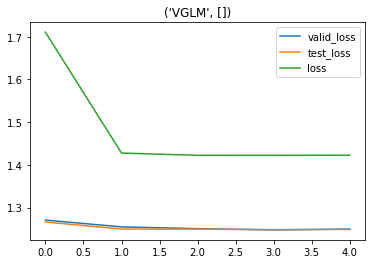

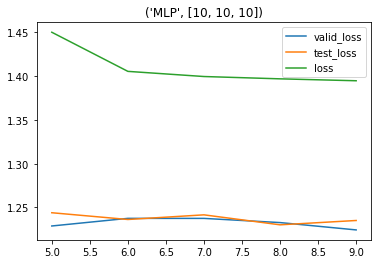

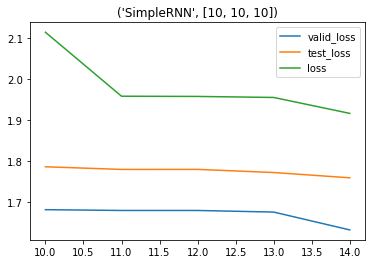

In [32]:
for i in a.model_arch.unique():
    a[['valid_loss','test_loss','loss']][a.model_arch == i].plot()
    plt.title(i)
    plt.show